In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

nlp = spacy.load("en_core_web_sm")
sbert = SentenceTransformer("all-MiniLM-L6-v2")

df = pd.read_parquet("../dataset/data/train-00000-of-00001.parquet")

print("="*60)
print("TASK 1: CLARITY CLASSIFICATION - DATA ANALYSIS")
print("="*60)
print(f"\nTotal rows: {len(df)}")
print(f"\nAll columns: {df.columns.tolist()}")

c:\Users\Aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
c:\Users\Aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(



TASK 1: CLARITY CLASSIFICATION - DATA ANALYSIS

Total rows: 3448

All columns: ['title', 'date', 'president', 'url', 'question_order', 'interview_question', 'interview_answer', 'gpt3.5_summary', 'gpt3.5_prediction', 'question', 'annotator_id', 'annotator1', 'annotator2', 'annotator3', 'inaudible', 'multiple_questions', 'affirmative_questions', 'index', 'clarity_label', 'evasion_label']


In [2]:
print("\nClarity Label Distribution:")
print(df["clarity_label"].value_counts())
print(f"\nPercentages:")
print(df["clarity_label"].value_counts(normalize=True) * 100)


Clarity Label Distribution:
clarity_label
Ambivalent         2040
Clear Reply        1052
Clear Non-Reply     356
Name: count, dtype: int64

Percentages:
clarity_label
Ambivalent         59.164733
Clear Reply        30.510441
Clear Non-Reply    10.324826
Name: proportion, dtype: float64


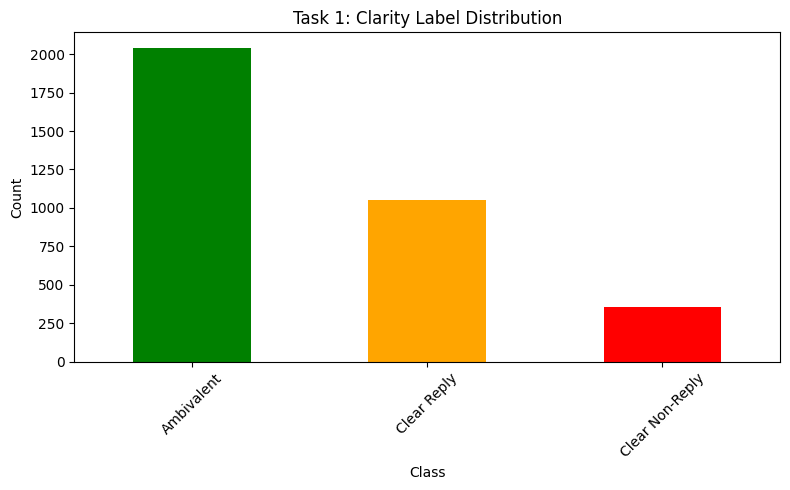

In [3]:
plt.figure(figsize=(8, 5))
df["clarity_label"].value_counts().plot(
    kind='bar', color=['green', 'orange', 'red'])
plt.title("Task 1: Clarity Label Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
for label in df["clarity_label"].unique():
    subset = df[df["clarity_label"] == label]
    print(f"\n{'='*50}")
    print(f"CLASS: {label} ({len(subset)} samples)")
    print(f"{'='*50}")
    print(
        f"Avg answer length (words): {subset['interview_answer'].str.split().str.len().mean():.1f}")
    print(
        f"Avg question length (words): {subset['question'].str.split().str.len().mean():.1f}")


CLASS: Clear Reply (1052 samples)
Avg answer length (words): 272.0
Avg question length (words): 13.5

CLASS: Ambivalent (2040 samples)
Avg answer length (words): 331.9
Avg question length (words): 15.3

CLASS: Clear Non-Reply (356 samples)
Avg answer length (words): 137.8
Avg question length (words): 12.6


In [5]:
print("\nComputing semantic similarity per class...")


def compute_similarity(row):
    q = str(row["question"])
    a = str(row["interview_answer"])[:1500]
    q_emb = sbert.encode(q)
    a_emb = sbert.encode(a)
    return 1 - cosine(q_emb, a_emb)


# Sample for speed (or use all if you have time)
sample_df = df.sample(min(500, len(df)), random_state=42).copy()
sample_df["semantic_sim"] = sample_df.apply(compute_similarity, axis=1)

print("\nSemantic Similarity by Class:")
for label in sample_df["clarity_label"].unique():
    subset = sample_df[sample_df["clarity_label"] == label]
    print(
        f"  {label}: mean={subset['semantic_sim'].mean():.3f}, std={subset['semantic_sim'].std():.3f}")


Computing semantic similarity per class...

Semantic Similarity by Class:
  Ambivalent: mean=0.323, std=0.177
  Clear Reply: mean=0.369, std=0.160
  Clear Non-Reply: mean=0.283, std=0.185


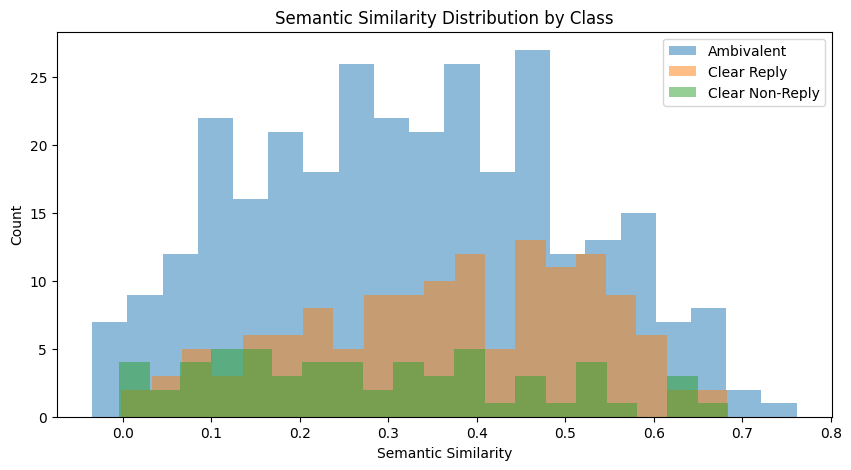

In [6]:
plt.figure(figsize=(10, 5))
for label in sample_df["clarity_label"].unique():
    subset = sample_df[sample_df["clarity_label"] == label]
    plt.hist(subset["semantic_sim"], bins=20, alpha=0.5, label=label)
plt.xlabel("Semantic Similarity")
plt.ylabel("Count")
plt.title("Semantic Similarity Distribution by Class")
plt.legend()
plt.show()

In [7]:
for label in df["clarity_label"].unique():
    subset = df[df["clarity_label"] == label]
    a_lower = subset["interview_answer"].str.lower()
    first_word = subset["interview_answer"].str.split().str[0].str.lower()

    print(f"\n{'='*50}")
    print(f"CLASS: {label}")
    print(f"{'='*50}")

    # Direct starters
    direct_yes = ["yes", "yeah", "absolutely", "definitely",
                  "certainly", "correct", "right", "sure"]
    direct_no = ["no", "nope", "not", "never"]

    starts_yes = first_word.isin(direct_yes).mean() * 100
    starts_no = first_word.isin(direct_no).mean() * 100
    starts_well = (first_word == "well").mean() * 100
    starts_i = (first_word == "i").mean() * 100

    print(f"  Starts with YES words: {starts_yes:.1f}%")
    print(f"  Starts with NO words: {starts_no:.1f}%")
    print(f"  Starts with 'well': {starts_well:.1f}%")
    print(f"  Starts with 'I': {starts_i:.1f}%")

    # Hedging
    hedges = ["maybe", "perhaps", "possibly", "might", "could"]
    has_hedge = a_lower.apply(lambda x: any(
        h in x for h in hedges)).mean() * 100
    print(f"  Contains hedges: {has_hedge:.1f}%")


CLASS: Clear Reply
  Starts with YES words: 0.5%
  Starts with NO words: 1.1%
  Starts with 'well': 0.7%
  Starts with 'I': 12.8%
  Contains hedges: 30.1%

CLASS: Ambivalent
  Starts with YES words: 0.2%
  Starts with NO words: 0.3%
  Starts with 'well': 0.9%
  Starts with 'I': 11.9%
  Contains hedges: 34.2%

CLASS: Clear Non-Reply
  Starts with YES words: 0.0%
  Starts with NO words: 0.6%
  Starts with 'well': 0.6%
  Starts with 'I': 20.2%
  Contains hedges: 17.7%


In [8]:
print("\n" + "="*70)
print("EXAMPLE ANSWERS FROM EACH CLASS")
print("="*70)

for label in df["clarity_label"].unique():
    subset = df[df["clarity_label"] == label].sample(3, random_state=42)
    print(f"\n--- {label} ---")
    for _, row in subset.iterrows():
        print(f"\nQ: {row['question'][:100]}...")
        print(f"A: {row['interview_answer'][:200]}...")
        print("-" * 40)


EXAMPLE ANSWERS FROM EACH CLASS

--- Clear Reply ---

Q: And could this signal your real losses for Democrats in the midterms?...
A: We're going to win. I think we're going to win in Virginia.And you know—you're reporting it being close—the race is very close. It's about who shows up, who turns out.And granted, I did win by a large...
----------------------------------------

Q:  What was the message you were trying to send with not only your decision not to attend the Sochi Ga...
A: Well, first of all, I haven't attended Olympics in the past, and I suspect that me attending the Olympics, particularly at a time when we've got all the other stuff that people have been talking about...
----------------------------------------

Q: When do you expect to see items like hand sanitizer back on the shelves?...
A: Well, I didn't suggest that it could happen, but I can tell you it's an industry that was very badly impacted by what's going on with the virus. And it's a great industry. It's a ver

In [9]:
if "evasion_label" in df.columns:
    print("\nCross-tabulation: Clarity vs Evasion Labels")
    print(pd.crosstab(df["clarity_label"], df["evasion_label"]))
elif "label" in df.columns:
    print("\nCross-tabulation: Clarity vs Label")
    print(pd.crosstab(df["clarity_label"], df["label"]))


Cross-tabulation: Clarity vs Evasion Labels
evasion_label    Claims ignorance  Clarification  Declining to answer  \
clarity_label                                                           
Ambivalent                      0              0                    0   
Clear Non-Reply               119             92                  145   
Clear Reply                     0              0                    0   

evasion_label    Deflection  Dodging  Explicit  General  Implicit  \
clarity_label                                                       
Ambivalent              381      706         0      386       488   
Clear Non-Reply           0        0         0        0         0   
Clear Reply               0        0      1052        0         0   

evasion_label    Partial/half-answer  
clarity_label                         
Ambivalent                        79  
Clear Non-Reply                    0  
Clear Reply                        0  
